# 🩸 Global Blood Donation Registry — Decision‑Grade

This notebook transforms the provided data into calibrated donor scores and budgeted outreach decisions:

- Score **eligible** donors with a calibrated `P(donated_next_6m)`
- Convert scores into **Top‑K** and **threshold** contact actions
- *(Optional)* Add an ops lens: compatibility‑based **demand vs supply** and a **stress index**

**Inputs**
- `blood_donation_registry_ml_ready.csv`
- `blood_population_distribution.csv`
- *(optional)* `blood_compatibility_lookup.csv`

**Exports (saved to `artifacts/`)**
- `donor_outreach_scored.csv`
- `model_bundle.joblib`
- `metrics_holdout.json`


In [109]:
from __future__ import annotations

import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

SEED = 42
RNG = np.random.default_rng(SEED)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

plt.rcParams["figure.figsize"] = (8.6, 4.2)
plt.rcParams["figure.dpi"] = 140


## 0) Load Data

In [110]:
from pathlib import Path
import pandas as pd

# Local folder (recommended): place CSVs under data/raw/
local_dir = Path('data/raw')
# Kaggle dataset folder (fallback)
kaggle_dir = Path('/kaggle/input/blood-donor-registry-dataset') / 'data'

def _read_csv(filename: str) -> pd.DataFrame:
    local_path = local_dir / filename
    kaggle_path = kaggle_dir / filename
    if local_path.exists():
        return pd.read_csv(local_path)
    return pd.read_csv(kaggle_path)

donors = _read_csv('blood_donation_registry_ml_ready.csv')
pop    = _read_csv('blood_population_distribution.csv')
compat = _read_csv('blood_compatibility_lookup.csv')
# data dictionary lives under docs in the Kaggle dataset; locally keep it in data/raw as well
ddict_local = local_dir / 'data_dictionary.csv'
ddict_kaggle = (Path('/kaggle/input/blood-donor-registry-dataset') / 'docs' / 'data_dictionary.csv')
ddict = pd.read_csv(ddict_local) if ddict_local.exists() else pd.read_csv(ddict_kaggle)

print('donors:', donors.shape)
print('pop   :', pop.shape)
print('compat:', compat.shape)
print('ddict :', ddict.shape)


donors: (30000, 27)
pop   : (39, 12)
compat: (64, 4)
ddict : (43, 6)


## 1) Data contract 

Minimal, high-signal checks to prevent fake confidence.

In [111]:
def require_cols(df: pd.DataFrame, cols: list[str], name: str) -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{name} missing columns: {missing}")

REQ_DONORS = [
    "donor_id", "country_code", "region", "blood_type",
    "eligible_to_donate", "donated_next_6m",
    "recency_days", "donation_count_last_12m",
]
REQ_POP = ["country_code", "population_size"]

require_cols(donors, REQ_DONORS, "donors")
require_cols(pop, REQ_POP, "pop")

def frac_ok(mask: pd.Series) -> float:
    return float(np.mean(mask.astype(bool)))

checks = []

dup = int(donors["donor_id"].duplicated().sum())
checks.append(("donor_id unique", dup == 0, f"duplicates={dup}"))

miss = donors.isna().mean().sort_values(ascending=False)
miss = miss[miss > 0]
checks.append(("missingness", True, "none" if len(miss) == 0 else ", ".join([f"{k}={v:.1%}" for k, v in miss.head(6).items()])))

if "age" in donors.columns:
    f = frac_ok((donors["age"] >= 18) & (donors["age"] <= 75))
    checks.append(("age ~[18,75]", f >= 0.99, f"pass_rate={f:.3f}"))

if "bmi" in donors.columns:
    f = frac_ok((donors["bmi"] >= 12) & (donors["bmi"] <= 55))
    checks.append(("bmi ~[12,55]", f >= 0.99, f"pass_rate={f:.3f}"))

f = frac_ok((donors["recency_days"] >= 0) & (donors["recency_days"] <= 4000))
checks.append(("recency_days >=0", f >= 0.999, f"pass_rate={f:.3f}"))

contract = pd.DataFrame(checks, columns=["check", "pass", "details"])
display(contract)


,check,pass,details
0,donor_id unique,True,duplicates=0
1,missingness,True,deferral_reason=83.0%
2,"age ~[18,75]",True,pass_rate=1.000
3,"bmi ~[12,55]",True,pass_rate=1.000
4,recency_days >=0,False,pass_rate=0.967


## 2) Snapshot KPIs (one screen)

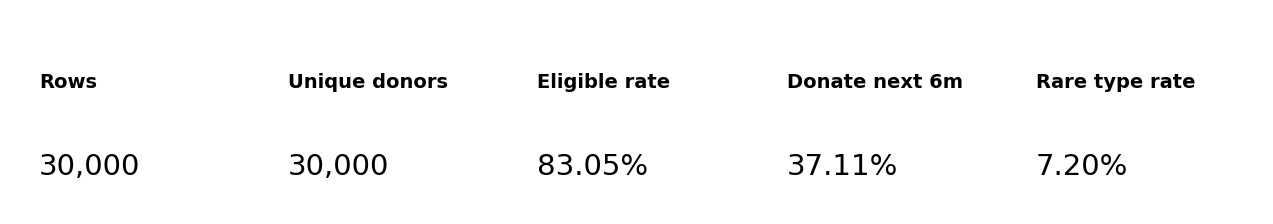

In [112]:
kpis = {
    "Rows": f"{len(donors):,}",
    "Unique donors": f"{int(donors['donor_id'].nunique()):,}",
    "Eligible rate": f"{float(donors['eligible_to_donate'].mean()):.2%}",
    "Donate next 6m": f"{float(donors['donated_next_6m'].mean()):.2%}",
}
if "is_rare_type" in donors.columns:
    kpis["Rare type rate"] = f"{float(donors['is_rare_type'].mean()):.2%}"

fig, ax = plt.subplots(figsize=(9.2, 1.7))
ax.axis("off")
x = 0.02
step = 0.24 if len(kpis) <= 4 else 0.20
for label, val in kpis.items():
    ax.text(x, 0.62, label, fontsize=10, fontweight="bold")
    ax.text(x, 0.18, val, fontsize=15)
    x += step
plt.tight_layout()
plt.show()


## 3) Outreach map — Recency × Frequency (eligible only)

This is the operational targeting view: **cells with higher values are better candidates** under a fixed outreach budget.

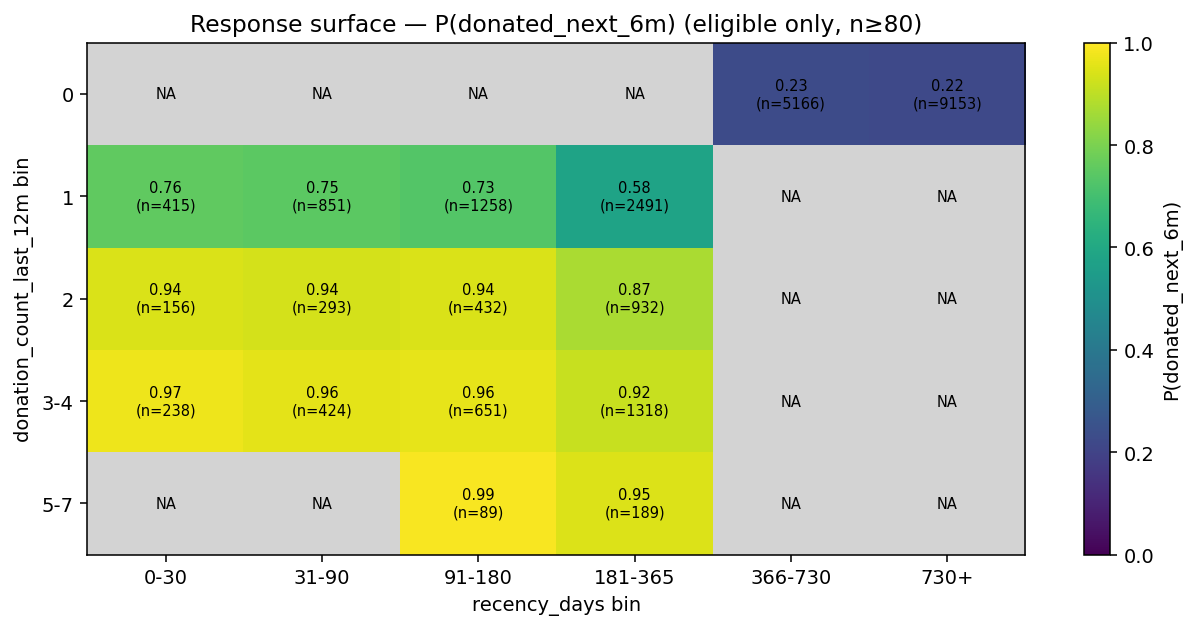

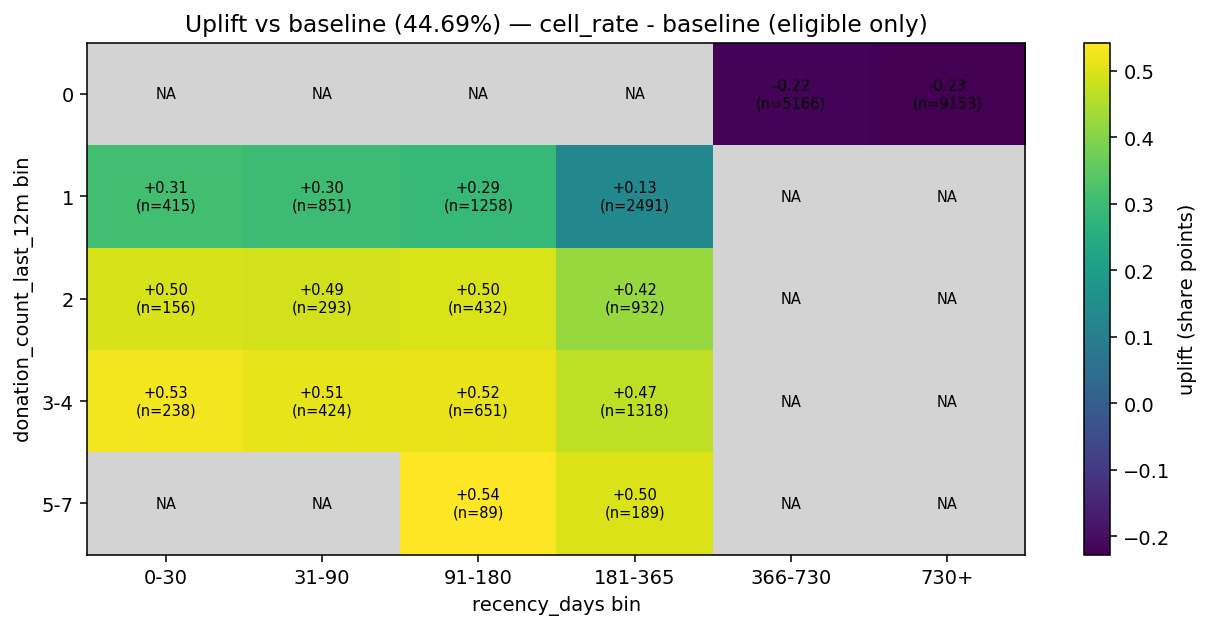

In [113]:

TARGET = "donated_next_6m"
eligible = donors[donors["eligible_to_donate"] == 1].copy()

rec_bins   = [0, 30, 90, 180, 365, 730, 4000]
rec_labels = ["0-30", "31-90", "91-180", "181-365", "366-730", "730+"]

freq_bins   = [-0.1, 0, 1, 2, 4, 7, 100]
freq_labels = ["0", "1", "2", "3-4", "5-7", "7+"]

eligible["_rec_bin"]  = pd.cut(eligible["recency_days"], rec_bins, labels=rec_labels, include_lowest=True)
eligible["_freq_bin"] = pd.cut(eligible["donation_count_last_12m"], freq_bins, labels=freq_labels, include_lowest=True)

rate = eligible.pivot_table(
    index="_freq_bin", columns="_rec_bin", values=TARGET, aggfunc="mean", observed=True
)
cnt = eligible.pivot_table(
    index="_freq_bin", columns="_rec_bin", values=TARGET, aggfunc="size", observed=True
)

cnt = cnt.reindex_like(rate).fillna(0).astype(int)

MIN_N = 80
rate_f = rate.where(cnt >= MIN_N)

# -------- Plot 1: Response surface --------
Z = rate_f.to_numpy(dtype=float)

vmin_rate, vmax_rate = 0.0, 1.0
sentinel_rate = vmin_rate - 1.0
Z_plot = Z.copy()
Z_plot[~np.isfinite(Z_plot)] = sentinel_rate

cmap = plt.cm.viridis.copy()
cmap.set_under("lightgray")

plt.figure(figsize=(9.2, 4.6))
im = plt.imshow(
    Z_plot,
    aspect="auto",
    interpolation="nearest",
    cmap=cmap,
    vmin=vmin_rate,
    vmax=vmax_rate,
)
plt.title(f"Response surface — P({TARGET}) (eligible only, n≥{MIN_N})")
plt.xlabel("recency_days bin")
plt.ylabel("donation_count_last_12m bin")
plt.xticks(np.arange(len(rate.columns)), rate.columns.astype(str))
plt.yticks(np.arange(len(rate.index)), rate.index.astype(str))

for i in range(rate.shape[0]):
    for j in range(rate.shape[1]):
        n = int(cnt.iloc[i, j])
        v = rate_f.iloc[i, j]
        txt = "NA" if pd.isna(v) else f"{float(v):.2f}\n(n={n})"
        plt.text(j, i, txt, ha="center", va="center", fontsize=7.5)

plt.colorbar(im, label=f"P({TARGET})")
plt.tight_layout()
plt.show()

# -------- Plot 2: Uplift vs baseline --------
base = float(eligible[TARGET].mean())
uplift_f = (rate - base).where(cnt >= MIN_N)

U = uplift_f.to_numpy(dtype=float)
valid_u = np.isfinite(U)

if valid_u.any():
    umin = float(np.nanmin(U[valid_u]))
    umax = float(np.nanmax(U[valid_u]))
else:
    umin, umax = -0.1, 0.1

sentinel_u = umin - 1.0
U_plot = U.copy()
U_plot[~np.isfinite(U_plot)] = sentinel_u

cmap_u = plt.cm.viridis.copy()
cmap_u.set_under("lightgray")

plt.figure(figsize=(9.2, 4.6))
im = plt.imshow(
    U_plot,
    aspect="auto",
    interpolation="nearest",
    cmap=cmap_u,
    vmin=umin,
    vmax=umax,
)
plt.title(f"Uplift vs baseline ({base:.2%}) — cell_rate - baseline (eligible only)")
plt.xlabel("recency_days bin")
plt.ylabel("donation_count_last_12m bin")
plt.xticks(np.arange(len(rate.columns)), rate.columns.astype(str))
plt.yticks(np.arange(len(rate.index)), rate.index.astype(str))

for i in range(rate.shape[0]):
    for j in range(rate.shape[1]):
        n = int(cnt.iloc[i, j])
        v = uplift_f.iloc[i, j]
        txt = "NA" if pd.isna(v) else f"{float(v):+.2f}\n(n={n})"
        plt.text(j, i, txt, ha="center", va="center", fontsize=7.5)

plt.colorbar(im, label="uplift (share points)")
plt.tight_layout()
plt.show()


## 4) Realism check — Donors vs population-weighted blood types

This answers: *is the donor pool representative relative to population prevalence?*

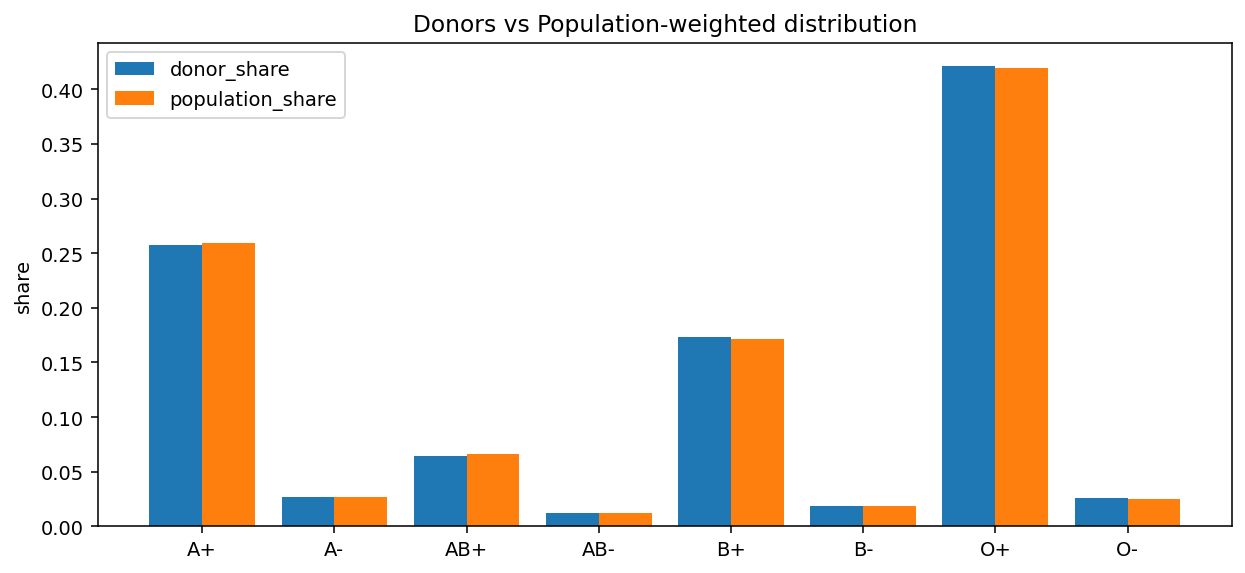

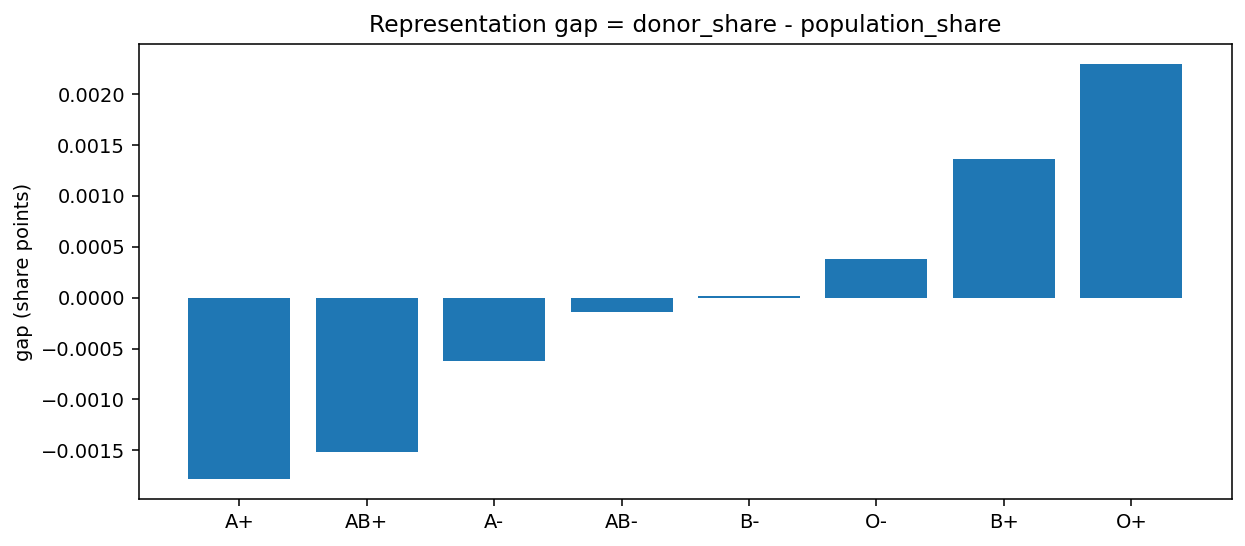

In [114]:
bt_cols = {
    "O+": "p_o_pos", "O-": "p_o_neg",
    "A+": "p_a_pos", "A-": "p_a_neg",
    "B+": "p_b_pos", "B-": "p_b_neg",
    "AB+": "p_ab_pos", "AB-": "p_ab_neg",
}

donor_dist = donors["blood_type"].astype(str).str.strip().value_counts(normalize=True).sort_index()

w = pop["population_size"].astype(float).to_numpy()
pop_dist = {}
for bt, col in bt_cols.items():
    if col in pop.columns:
        pop_dist[bt] = float((pop[col].astype(float).to_numpy() * w).sum() / w.sum())
pop_dist = pd.Series(pop_dist).sort_index()

all_bt = sorted(set(donor_dist.index).union(set(pop_dist.index)))
donor_al = donor_dist.reindex(all_bt).fillna(0.0)
pop_al   = pop_dist.reindex(all_bt).fillna(0.0)

x = np.arange(len(all_bt))
plt.figure(figsize=(9.0, 4.2))
plt.bar(x - 0.2, donor_al.to_numpy(), width=0.4, label="donor_share")
plt.bar(x + 0.2, pop_al.to_numpy(),   width=0.4, label="population_share")
plt.xticks(x, all_bt)
plt.title("Donors vs Population-weighted distribution")
plt.ylabel("share")
plt.legend()
plt.tight_layout()
plt.show()

gap = (donor_al - pop_al).sort_values()
plt.figure(figsize=(9.0, 4.0))
plt.bar(gap.index.astype(str), gap.to_numpy())
plt.title("Representation gap = donor_share - population_share")
plt.ylabel("gap (share points)")
plt.tight_layout()
plt.show()


## 5) Ops stress — Compatibility demand vs supply

,compatible_donor_share
recipient_blood_type,
AB+,1.000000
A+,0.731367
B+,0.639833
O+,0.447533
AB-,0.083333
A-,0.052467
B-,0.044933
O-,0.025900


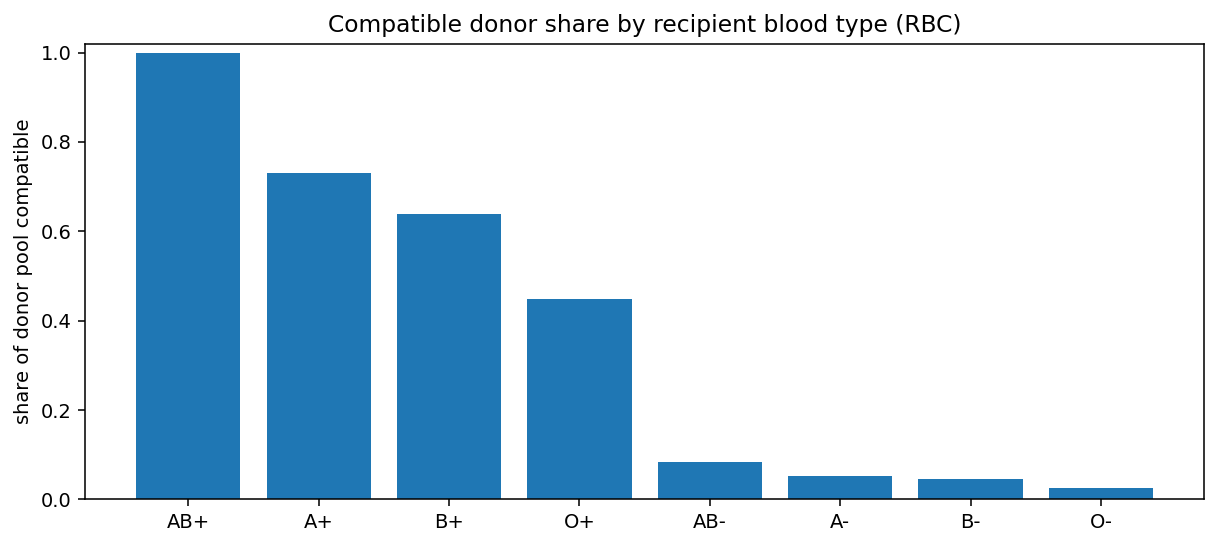

,recipient_blood_type,compatible_supply,demand,stress_index
0,O-,0.025900,0.025516,0.985166
1,O+,0.447533,0.419341,0.937005
2,A-,0.052467,0.027191,0.518245
3,A+,0.731367,0.259045,0.354193
4,B-,0.044933,0.019017,0.423224
5,B+,0.639833,0.171900,0.268664
6,AB-,0.083333,0.011972,0.143666
7,AB+,1.000000,0.066018,0.066018


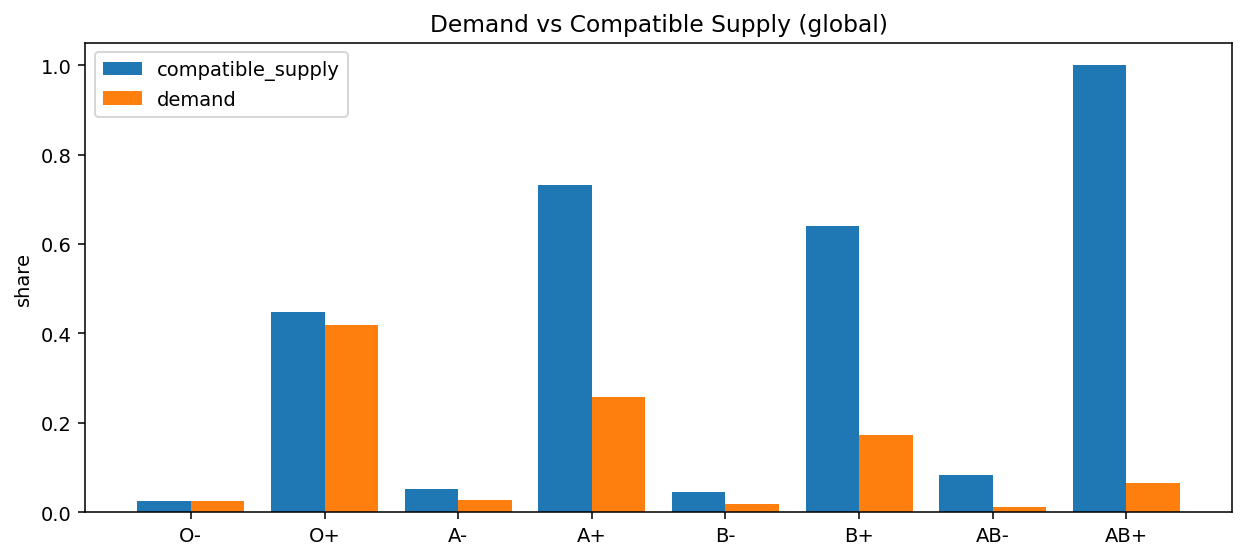

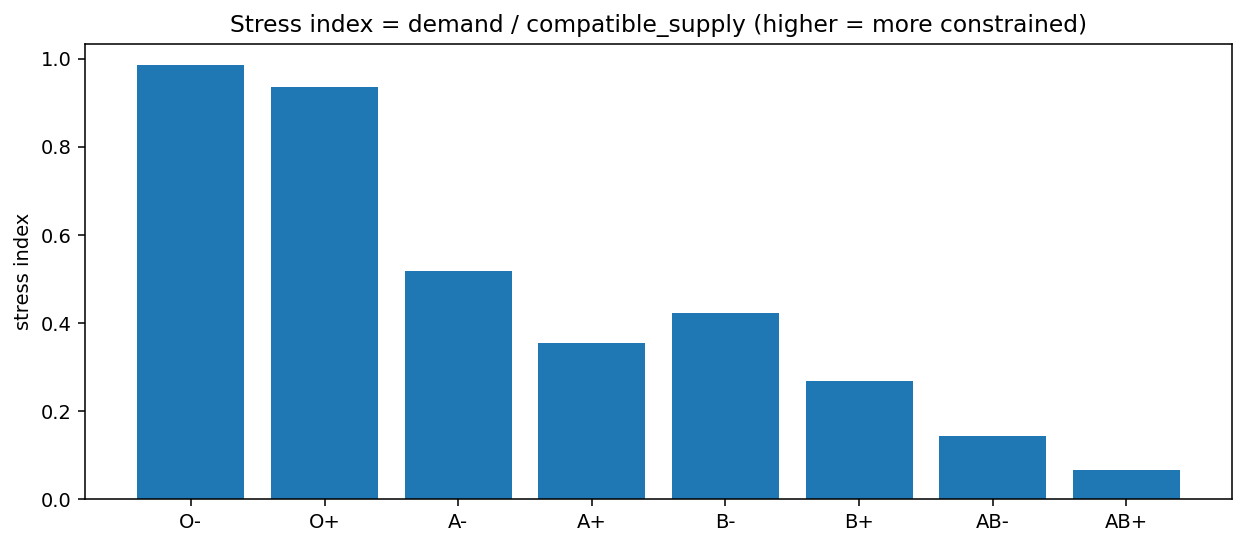

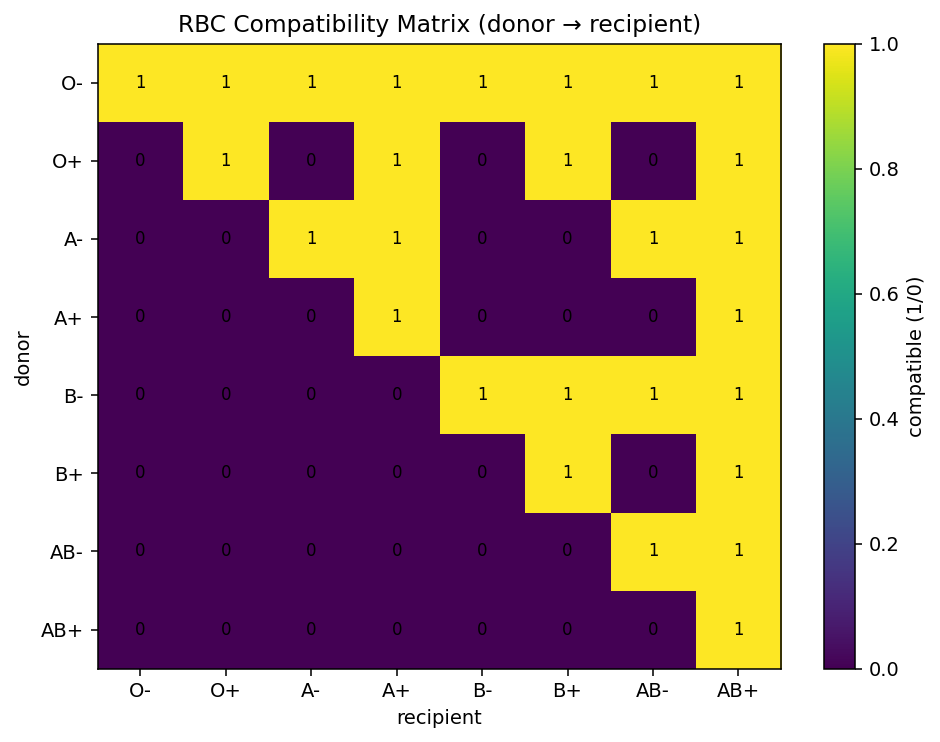

In [115]:
import re

def _snake(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s).strip("_")
    return s

def _standardize_compat(df: pd.DataFrame) -> pd.DataFrame:
    c = df.copy()
    c.columns = [_snake(x) for x in c.columns]
    cols = list(c.columns)

    def pick(*candidates: str) -> str | None:
        for name in candidates:
            if name in cols:
                return name
        return None

    donor = pick("donor_blood_type", "donor_type", "donor_blood", "donor")
    recip = pick("recipient_blood_type", "recipient_type", "recipient_blood", "recipient", "recip_blood_type", "recip_type")
    comp  = pick("compatible_for_rbc_transfusion", "compatible_rbc", "compatible", "is_compatible")

    if donor is None:
        for col in cols:
            if "donor" in col and ("blood" in col or "type" in col):
                donor = col; break
    if recip is None:
        for col in cols:
            if ("recipient" in col or "recip" in col) and ("blood" in col or "type" in col):
                recip = col; break
    if comp is None:
        for col in cols:
            if "compat" in col:
                comp = col; break

    if donor is None or recip is None or comp is None:
        return pd.DataFrame()

    out = c.rename(columns={donor: "donor_blood_type", recip: "recipient_blood_type", comp: "compatible_for_rbc_transfusion"})
    out = out[["donor_blood_type", "recipient_blood_type", "compatible_for_rbc_transfusion"]].copy()

    out["donor_blood_type"] = out["donor_blood_type"].astype(str).str.strip()
    out["recipient_blood_type"] = out["recipient_blood_type"].astype(str).str.strip()
    out["compatible_for_rbc_transfusion"] = pd.to_numeric(out["compatible_for_rbc_transfusion"], errors="coerce").fillna(0).astype(int)
    return out

if compat is None:
    print("compatibility file not found → skipping ops stress.")
else:
    c = _standardize_compat(compat)
    if c.empty:
        print("compatibility columns not recognized → skipping ops stress.")
        print("found columns:", list(compat.columns))
    else:
        donor_share = donors["blood_type"].astype(str).str.strip().value_counts(normalize=True).rename("donor_share").reset_index()
        donor_share.columns = ["donor_blood_type", "donor_share"]

        cov = c.merge(donor_share, on="donor_blood_type", how="left")
        cov["donor_share"] = cov["donor_share"].fillna(0.0)
        cov["contrib"] = cov["compatible_for_rbc_transfusion"].astype(float) * cov["donor_share"]

        cov_by_rec = cov.groupby("recipient_blood_type")["contrib"].sum().sort_values(ascending=False)
        display(cov_by_rec.to_frame("compatible_donor_share").round(6))

        plt.figure(figsize=(8.8, 4.0))
        plt.bar(cov_by_rec.index.astype(str), cov_by_rec.to_numpy())
        plt.title("Compatible donor share by recipient blood type (RBC)")
        plt.ylabel("share of donor pool compatible")
        plt.ylim(0, 1.02)
        plt.tight_layout()
        plt.show()

        # population-weighted demand share
        demand = {}
        for bt, col in bt_cols.items():
            if col in pop.columns:
                demand[bt] = float((pop[col].astype(float).to_numpy() * w).sum() / w.sum())

        blood_types = ["O-", "O+", "A-", "A+", "B-", "B+", "AB-", "AB+"]

        rows = []
        for bt in blood_types:
            supply = float(cov_by_rec.get(bt, 0.0))
            dem = float(demand.get(bt, np.nan))
            stress = (dem / supply) if (supply > 1e-12 and not np.isnan(dem)) else np.nan
            rows.append((bt, supply, dem, stress))

        stress_df = pd.DataFrame(rows, columns=["recipient_blood_type", "compatible_supply", "demand", "stress_index"])
        display(stress_df.round(6))

        x = np.arange(len(blood_types))
        plt.figure(figsize=(9.0, 4.1))
        plt.bar(x - 0.2, stress_df["compatible_supply"].to_numpy(), width=0.4, label="compatible_supply")
        plt.bar(x + 0.2, stress_df["demand"].to_numpy(),            width=0.4, label="demand")
        plt.xticks(x, blood_types)
        plt.title("Demand vs Compatible Supply (global)")
        plt.ylabel("share")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(9.0, 4.0))
        plt.bar(blood_types, stress_df["stress_index"].to_numpy())
        plt.title("Stress index = demand / compatible_supply (higher = more constrained)")
        plt.ylabel("stress index")
        plt.tight_layout()
        plt.show()

        # Compatibility matrix (donor -> recipient)
        mat = cov.pivot_table(
            index="donor_blood_type",
            columns="recipient_blood_type",
            values="compatible_for_rbc_transfusion",
            aggfunc="max",
        ).reindex(index=blood_types, columns=blood_types)

        plt.figure(figsize=(7.0, 5.4))
        im = plt.imshow(mat.to_numpy(), interpolation="nearest", aspect="auto")
        plt.title("RBC Compatibility Matrix (donor → recipient)")
        plt.xlabel("recipient")
        plt.ylabel("donor")
        plt.xticks(np.arange(len(blood_types)), blood_types)
        plt.yticks(np.arange(len(blood_types)), blood_types)
        for i in range(len(blood_types)):
            for j in range(len(blood_types)):
                v = mat.iloc[i, j]
                plt.text(j, i, "1" if v == 1 else "0", ha="center", va="center", fontsize=8.5)
        plt.colorbar(im, label="compatible (1/0)")
        plt.tight_layout()
        plt.show()


## 6) Model — Calibrated outreach score (eligible only)

Baseline model + isotonic calibration → calibrated `P(donated_next_6m)`.

,roc_auc,pr_auc,brier
0,0.80888,0.79989,0.16078


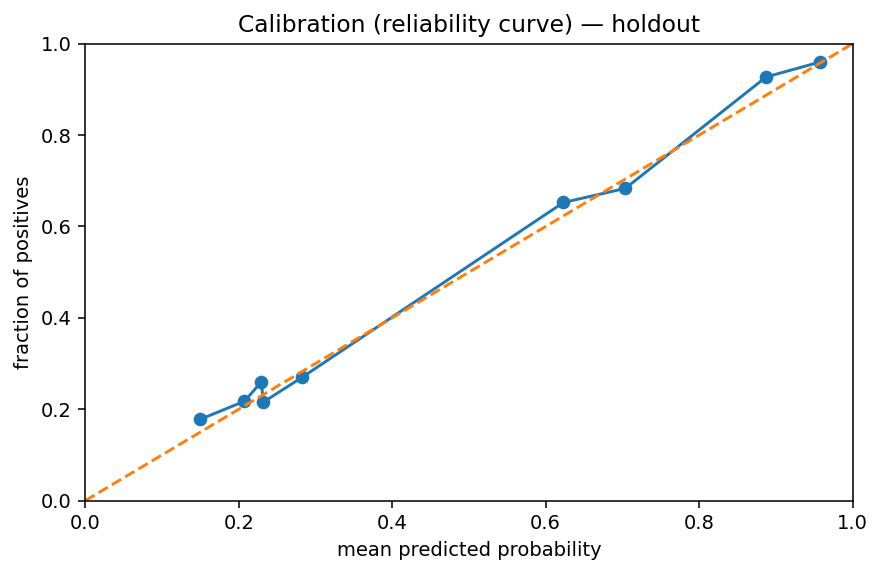

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

elig = donors[donors["eligible_to_donate"] == 1].copy()

TARGET = "donated_next_6m"

# drop obvious non-features / post-period-like fields if they exist
drop_cols = [c for c in ["donor_id", "as_of_date", "last_donation_date"] if c in elig.columns]
drop_cols += [c for c in elig.columns if (c != TARGET and "next_6m" in c)]
if "donation_propensity_score" in elig.columns:
    drop_cols.append("donation_propensity_score")
drop_cols = sorted(set(drop_cols))

y = elig[TARGET].astype(int).to_numpy()
X = elig.drop(columns=(drop_cols + [TARGET, "eligible_to_donate"]), errors="ignore").copy()

num_cols = [c for c in ["age", "bmi", "donation_count_last_12m", "lifetime_donation_count",
                        "years_since_first_donation", "recency_days"] if c in X.columns]
cat_cols = [c for c in X.columns if c not in num_cols]

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=2500, solver="saga", random_state=SEED)),
])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)
X_tr2, X_cal, y_tr2, y_cal = train_test_split(X_tr, y_tr, test_size=0.25, random_state=SEED, stratify=y_tr)

pipe.fit(X_tr2, y_tr2)

p_cal = pipe.predict_proba(X_cal)[:, 1]
cal = IsotonicRegression(out_of_bounds="clip")
cal.fit(p_cal, y_cal)

p_te_raw = pipe.predict_proba(X_te)[:, 1]
p_te = cal.transform(p_te_raw)

metrics = {
    "roc_auc": float(roc_auc_score(y_te, p_te)),
    "pr_auc": float(average_precision_score(y_te, p_te)),
    "brier": float(brier_score_loss(y_te, p_te)),
}
display(pd.DataFrame([metrics]).round(5))

prob_true, prob_pred = calibration_curve(y_te, p_te, n_bins=10, strategy="quantile")

plt.figure(figsize=(6.4, 4.2))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Calibration (reliability curve) — holdout")
plt.xlabel("mean predicted probability")
plt.ylabel("fraction of positives")
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()


## 7) Budget curves — Deciles, Gains/Lift, Frontier

,decile,n,response_rate,avg_score,cum_n,cum_positives,cum_capture,lift_vs_base,contact_rate
0,"(0.909, 1.0]",372,0.959677,0.957235,372,357.0,0.160305,2.147316,0.074654
1,"(0.768, 0.909]",576,0.927083,0.887281,948,891.0,0.400090,2.074385,0.190247
2,"(0.65, 0.768]",401,0.683292,0.703802,1349,1165.0,0.523125,1.528892,0.270720
3,"(0.299, 0.65]",587,0.652470,0.623226,1936,1548.0,0.695106,1.459928,0.388521
4,"(0.232, 0.299]",397,0.269521,0.282299,2333,1655.0,0.743152,0.603065,0.468192
5,"(0.229, 0.232]",519,0.215800,0.232264,2852,1767.0,0.793444,0.482860,0.572346
6,"(0.21, 0.229]",420,0.259524,0.229381,3272,1876.0,0.842389,0.580695,0.656633
7,"(0.154, 0.21]",1177,0.217502,0.207463,4449,2132.0,0.957342,0.486670,0.892836
8,"(-0.001, 0.154]",534,0.177903,0.149840,4983,2227.0,1.000000,0.398064,1.000000


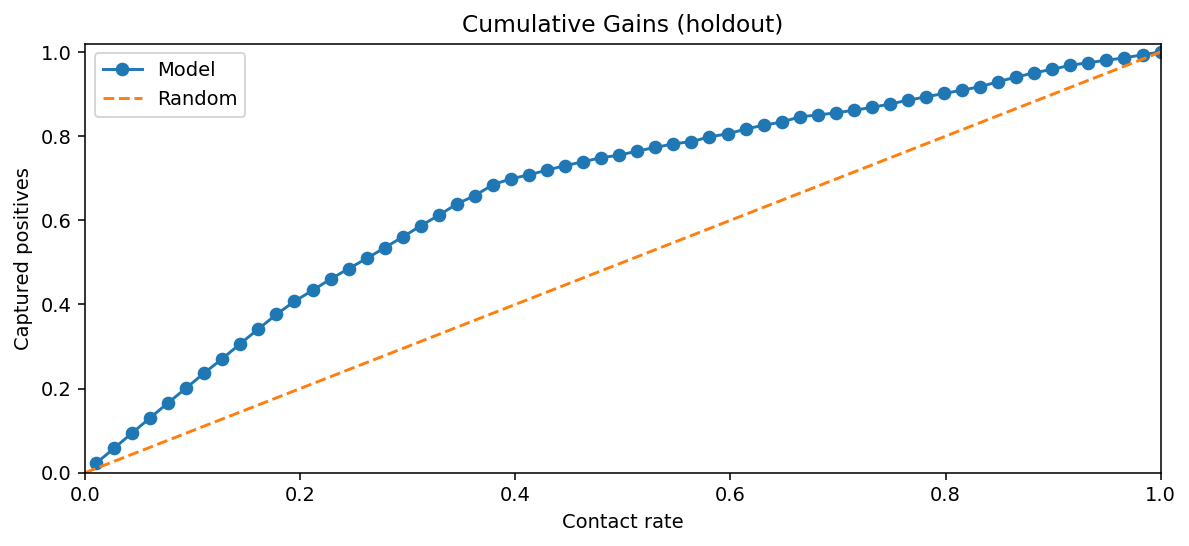

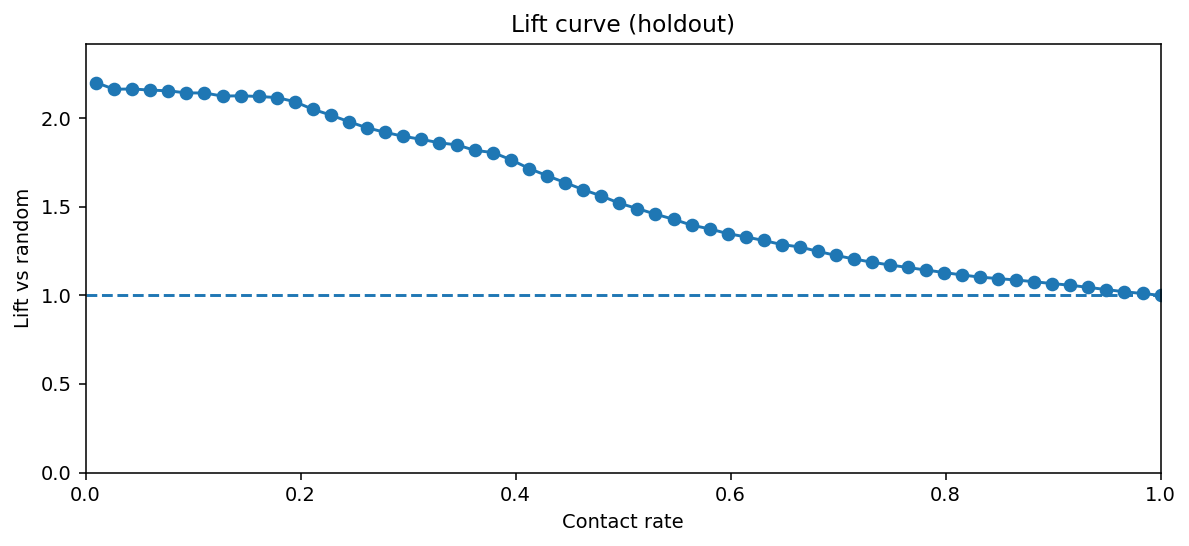

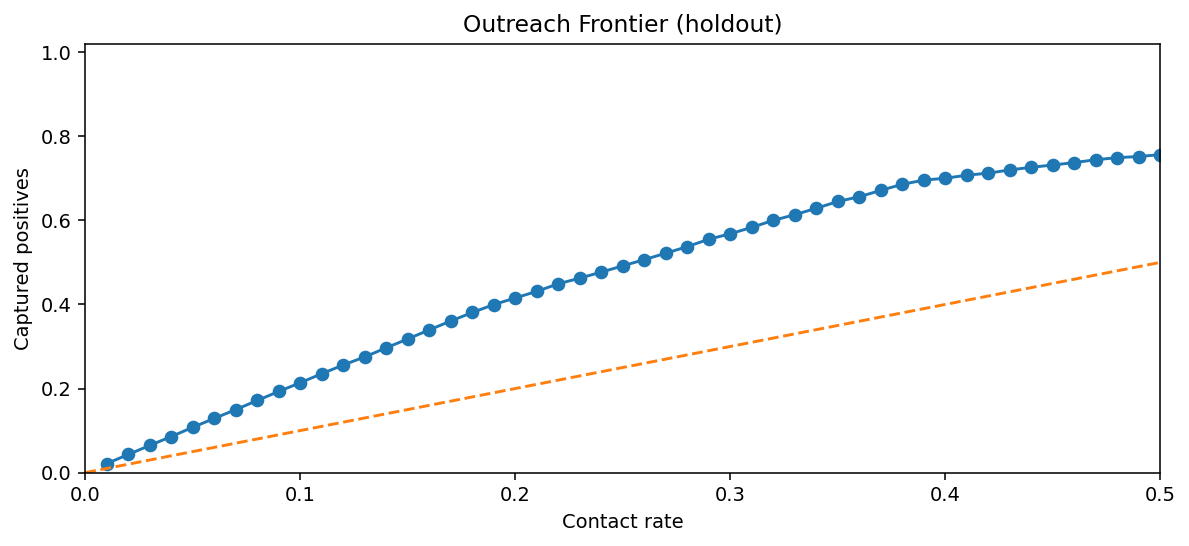

In [117]:
def decile_table(y_true: np.ndarray, score: np.ndarray, n_bins: int = 10) -> pd.DataFrame:
    df = pd.DataFrame({"y": y_true, "score": score})
    df["decile"] = pd.qcut(df["score"], q=n_bins, duplicates="drop")
    out = (
        df.groupby("decile", observed=True)
        .agg(n=("y", "size"), response_rate=("y", "mean"), avg_score=("score", "mean"))
        .reset_index()
        .sort_values("decile", ascending=False)
        .reset_index(drop=True)
    )
    out["cum_n"] = out["n"].cumsum()
    out["cum_positives"] = (out["response_rate"] * out["n"]).cumsum()
    out["cum_capture"] = out["cum_positives"] / (df["y"].sum() + 1e-12)
    base = df["y"].mean()
    out["lift_vs_base"] = out["response_rate"] / (base + 1e-12)
    out["contact_rate"] = out["cum_n"] / len(df)
    return out

dec = decile_table(y_te, p_te, 10)
display(dec)

def gains_lift(y_true: np.ndarray, score: np.ndarray, n_points: int = 60):
    order = np.argsort(-score)
    y_s = y_true[order]
    cum = np.cumsum(y_s)
    total = cum[-1]
    frac = np.linspace(0.01, 1.0, n_points)
    idx = (frac * (len(y_s) - 1)).astype(int)
    gains = cum[idx] / (total + 1e-12)
    lift = gains / frac
    return frac, gains, lift

frac, gains, lift = gains_lift(y_te, p_te)

plt.figure(figsize=(8.6, 4.0))
plt.plot(frac, gains, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.title("Cumulative Gains (holdout)")
plt.xlabel("Contact rate")
plt.ylabel("Captured positives")
plt.ylim(0, 1.02)
plt.xlim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8.6, 4.0))
plt.plot(frac, lift, marker="o")
plt.axhline(1.0, linestyle="--")
plt.title("Lift curve (holdout)")
plt.xlabel("Contact rate")
plt.ylabel("Lift vs random")
plt.ylim(0, max(1.05, float(lift.max()) * 1.1))
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

# frontier up to 50% outreach
order = np.argsort(-p_te)
y_sorted = y_te[order]
cum_pos = np.cumsum(y_sorted)
tot = cum_pos[-1]

rates = np.linspace(0.01, 0.50, 50)
front = []
for r in rates:
    k = max(1, int(r * len(y_sorted)))
    front.append(float(cum_pos[k - 1] / (tot + 1e-12)))

plt.figure(figsize=(8.6, 4.0))
plt.plot(rates, front, marker="o")
plt.plot([0, 0.50], [0, 0.50], linestyle="--")
plt.title("Outreach Frontier (holdout)")
plt.xlabel("Contact rate")
plt.ylabel("Captured positives")
plt.ylim(0, 1.02)
plt.xlim(0, 0.50)
plt.tight_layout()
plt.show()


## 8) Fingerprint — What makes Top‑10% different?

,feature,mean_top10,mean_all,z_diff
0,recency_days,174.7308,1022.8726,-0.7396
4,age,42.0077,44.3117,-0.2185
5,bmi,26.2946,26.1992,0.0258
3,years_since_first_donation,15.3635,8.2306,1.1203
2,lifetime_donation_count,38.9288,10.1531,1.6726
1,donation_count_last_12m,3.6038,0.7600,2.3700


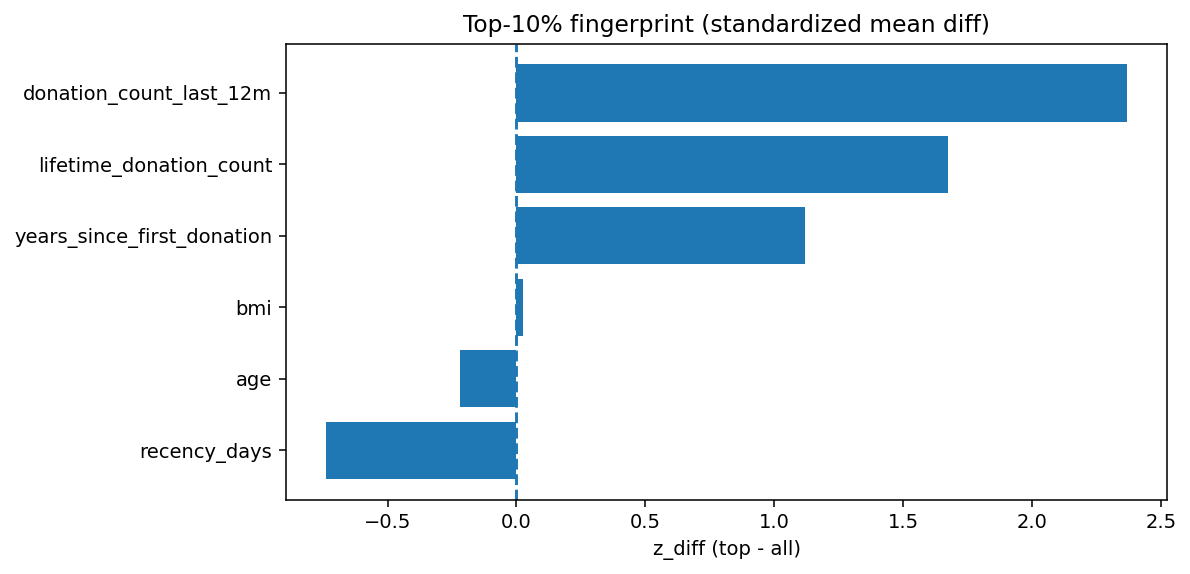

In [118]:
def segment_fingerprint(df: pd.DataFrame, score: np.ndarray, numeric_cols: list[str], top_q: float = 0.10):
    tmp = df.copy()
    tmp["_score"] = score
    thr = float(np.nanquantile(tmp["_score"].to_numpy(), 1 - top_q))
    top = tmp[tmp["_score"] >= thr]
    base = tmp

    rows = []
    for col in numeric_cols:
        if col not in tmp.columns:
            continue
        x_top = top[col].astype(float).to_numpy()
        x_base = base[col].astype(float).to_numpy()
        m_top = float(np.nanmean(x_top))
        m_base = float(np.nanmean(x_base))
        s_base = float(np.nanstd(x_base) + 1e-12)
        z = (m_top - m_base) / s_base
        rows.append((col, m_top, m_base, z))

    out = pd.DataFrame(rows, columns=["feature", "mean_top10", "mean_all", "z_diff"]).sort_values("z_diff")
    return out, thr

finger_cols = [c for c in ["recency_days", "donation_count_last_12m", "lifetime_donation_count",
                           "years_since_first_donation", "age", "bmi"] if c in X_te.columns]

fp, thr10 = segment_fingerprint(X_te, p_te, finger_cols, top_q=0.10)
display(fp.round(4))

plt.figure(figsize=(8.6, 4.2))
plt.barh(fp["feature"].astype(str), fp["z_diff"].to_numpy())
plt.axvline(0, linestyle="--")
plt.title("Top‑10% fingerprint (standardized mean diff)")
plt.xlabel("z_diff (top - all)")
plt.tight_layout()
plt.show()


## 9) Policy — Net benefit vs threshold

Choose the threshold that maximizes:

`net = benefit_per_success * TP - cost_per_contact * (TP + FP)`

,threshold,tp,fp,fn,tn,contacted,net
best,0.01,2225.0,2749.0,2.0,7.0,4974.0,17276.0


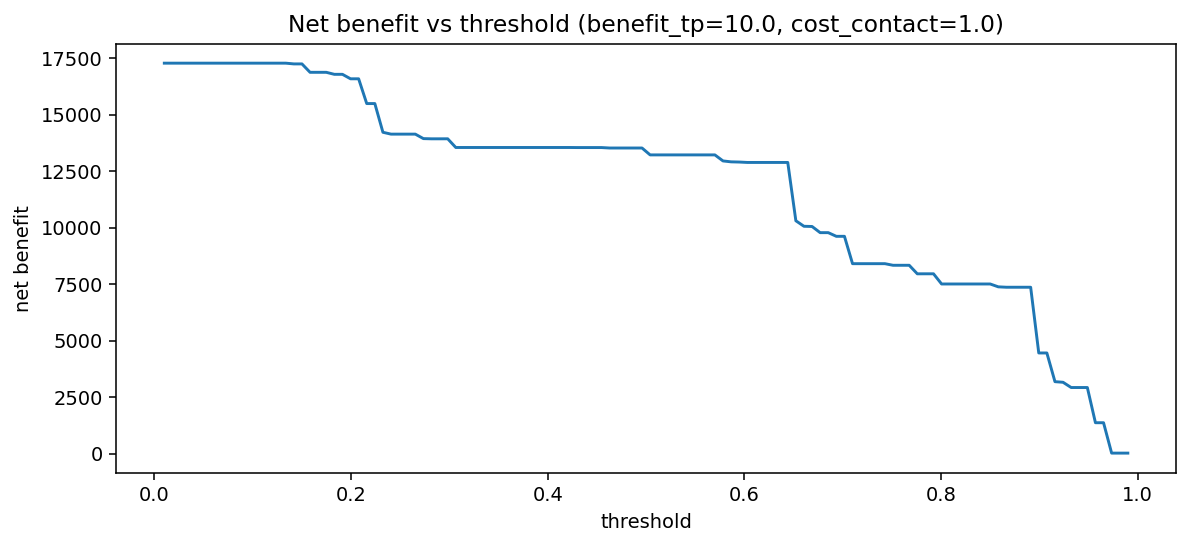

best_threshold = 0.01 | contacted = 4974 | net = 17276.0


In [119]:
def net_benefit_curve(y_true: np.ndarray, score: np.ndarray, benefit_tp: float, cost_contact: float, n_grid: int = 120):
    thr = np.linspace(0.01, 0.99, n_grid)
    rows = []
    for t in thr:
        y_pred = (score >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        contacted = tp + fp
        net = benefit_tp * tp - cost_contact * contacted
        rows.append((t, tp, fp, fn, tn, contacted, net))
    df = pd.DataFrame(rows, columns=["threshold", "tp", "fp", "fn", "tn", "contacted", "net"])
    best = df.loc[df["net"].idxmax()]
    return best, df

BENEFIT_TP = 10.0
COST_CONTACT = 1.0

best, curve = net_benefit_curve(y_te, p_te, BENEFIT_TP, COST_CONTACT)
display(best.to_frame("best").T)

plt.figure(figsize=(8.6, 4.0))
plt.plot(curve["threshold"], curve["net"])
plt.title(f"Net benefit vs threshold (benefit_tp={BENEFIT_TP}, cost_contact={COST_CONTACT})")
plt.xlabel("threshold")
plt.ylabel("net benefit")
plt.tight_layout()
plt.show()

t_best = float(best["threshold"])
print("best_threshold =", round(t_best, 4), "| contacted =", int(best["contacted"]), "| net =", round(float(best["net"]), 2))


## 10) Export artifacts

In [120]:
import json
import joblib
from pathlib import Path

import numpy as np
import pandas as pd

drop_global = [c for c in ["as_of_date", "last_donation_date"] if c in donors.columns]
drop_global += [c for c in donors.columns if (c != TARGET and "next_6m" in c)]
if "donation_propensity_score" in donors.columns:
    drop_global.append("donation_propensity_score")
drop_global = sorted(set(drop_global))

X_all = donors.drop(columns=(["donor_id"] + drop_global), errors="ignore").copy()

elig_mask = donors["eligible_to_donate"].astype(int).to_numpy() == 1
X_all_model = X_all.drop(columns=[TARGET, "eligible_to_donate"], errors="ignore")

if "X" in globals():
    X_all_model = X_all_model.reindex(columns=X.columns, fill_value=np.nan)

scores = np.full(len(donors), np.nan, dtype=float)

# Score only eligible rows 
if int(elig_mask.sum()) > 0:
    p_raw = pipe.predict_proba(X_all_model.loc[elig_mask])[:, 1]
    scores[elig_mask] = cal.transform(p_raw)

out_cols = [
    "donor_id", "country_code", "region", "blood_type", "eligible_to_donate",
    "recency_days", "donation_count_last_12m", TARGET
]
out_cols = [c for c in out_cols if c in donors.columns]

out = donors[out_cols].copy()
if "is_rare_type" in donors.columns:
    out["is_rare_type"] = donors["is_rare_type"]

out["outreach_score"] = scores


def topk_policy(score: np.ndarray, elig: np.ndarray, q: float) -> np.ndarray:
    """
    Returns 1 for eligible donors in the top-q fraction by score.
    Safe against NaNs and empty eligible sets (no RuntimeWarnings).
    """
    s = np.asarray(score, dtype=float)
    e = np.asarray(elig, dtype=bool)

    out = np.zeros_like(e, dtype=int)
    finite = e & np.isfinite(s)
    if finite.sum() == 0:
        return out

    thr = float(np.nanquantile(s[finite], 1.0 - q))
    if not np.isfinite(thr):
        return out

    out[finite] = (s[finite] >= thr).astype(int)
    return out


score_arr = out["outreach_score"].to_numpy(dtype=float)
finite_elig = elig_mask & np.isfinite(score_arr)

out["policy_top5pct_eligible"]  = topk_policy(score_arr, elig_mask, 0.05)
out["policy_top10pct_eligible"] = topk_policy(score_arr, elig_mask, 0.10)
out["policy_top20pct_eligible"] = topk_policy(score_arr, elig_mask, 0.20)

# Threshold policy (best net benefit) — compare only finite eligible scores
out["policy_threshold_best"] = 0
out.loc[finite_elig, "policy_threshold_best"] = (score_arr[finite_elig] >= float(t_best)).astype(int)

display(out.sort_values("outreach_score", ascending=False).head(12))

Path("artifacts").mkdir(exist_ok=True)
out.to_csv("artifacts/donor_outreach_scored.csv", index=False)

bundle = {"pipeline": pipe, "calibrator": cal, "seed": SEED, "mode": "eligible_only"}
joblib.dump(bundle, "artifacts/model_bundle.joblib")

with open("artifacts/metrics_holdout.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "metrics_holdout": metrics,
            "net_benefit_best": {k: float(best[k]) for k in ["threshold", "tp", "fp", "fn", "tn", "contacted", "net"]},
            "benefit_tp": float(BENEFIT_TP),
            "cost_contact": float(COST_CONTACT),
        },
        f,
        indent=2,
    )

print("Saved to artifacts/:")
print("- donor_outreach_scored.csv")
print("- model_bundle.joblib")
print("- metrics_holdout.json")


,donor_id,country_code,region,blood_type,eligible_to_donate,recency_days,donation_count_last_12m,donated_next_6m,is_rare_type,outreach_score,policy_top5pct_eligible,policy_top10pct_eligible,policy_top20pct_eligible,policy_threshold_best
11830,11831,GH,Africa,A+,1,289,5,1,0,1.0,1,1,1,1
20318,20319,KR,Asia,A+,1,222,5,1,0,1.0,1,1,1,1
22743,22744,KR,Asia,A+,1,307,5,1,0,1.0,1,1,1,1
19357,19358,KE,Africa,B+,1,68,5,1,0,1.0,1,1,1,1
27147,27148,BR,Americas,O+,1,197,5,1,0,1.0,1,1,1,1
22949,22950,MA,MENA,B+,1,147,5,1,0,1.0,1,1,1,1
3232,3233,IT,Europe,O+,1,303,5,1,0,1.0,1,1,1,1
15921,15922,PH,Asia,B+,1,48,5,1,0,1.0,1,1,1,1
1442,1443,NG,Africa,O-,1,44,5,1,1,1.0,1,1,1,1
22444,22445,KR,Asia,A+,1,216,5,1,0,1.0,1,1,1,1


Saved to artifacts/:
- donor_outreach_scored.csv
- model_bundle.joblib
- metrics_holdout.json


## Summary

- The **Outreach Map** (Recency × Frequency) is the simplest actionable targeting playbook.
- The **Realism Check** validates blood-type representation against population prevalence.
- The **Budget Curves** translate model scores into capacity-aware decisions.
- The notebook exports a reusable **scored table** + **model bundle** under `artifacts/`.